In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [3]:
from load_data import load_data_from_csv
from data_preprocessor.data_preprocessor import CompositeDataPreprocessor, ReduceMemUsageDataPreprocessor, FillNaPreProcessor
from data_preprocessor.feature_engineering import (
    BasicFeaturesPreprocessor,
    DupletsTripletsPreprocessor,
    MovingAvgPreProcessor,
    RemoveIrrelevantFeaturesDataPreprocessor,
    DropTargetNADataPreprocessor,
    FarNearPriceFillNaPreprocessor,
    MovingAvgFillNaPreprocessor,
    RemoveRecordsByStockDateIdPreprocessor,
)
from data_preprocessor.stock_feature_engineering import (
    StockNormalizeFeaturesPreprocessor,
)
from data_preprocessor.polynomial_features import PolynomialFeaturesPreProcessor
from data_preprocessor.stockid_features import StockIdFeaturesPreProcessor
# from data_preprocessor.deep_feature_synthesis import DfsPreProcessor
from data_generator.data_generator import DefaultTrainEvalDataGenerator, ManualKFoldDataGenerator, TimeSeriesKFoldDataGenerator

from model_post_processor.model_post_processor import CompositeModelPostProcessor, SaveModelPostProcessor, KerasSaveModelPostProcessor

from train_pipeline.train_pipeline import DefaultTrainPipeline

from train_pipeline.train_pipeline_callbacks import MAECallback
from utils.scoring_utils import ScoringUtils
from model_pipeline.dummy_models import BaselineEstimator

import numpy as np

import sys
import pandas as pd
import json

from sklearn import preprocessing

from model_pipeline.mlp_pipeline import MLPModelPipelineFactory

In [4]:
N_fold = 5
model_save_dir = './models'

processors = [    
    ReduceMemUsageDataPreprocessor(verbose=True),
    RemoveRecordsByStockDateIdPreprocessor([
        {"stock_id": 19, "date_id": 438},
        {"stock_id": 101, "date_id": 328},
        {"stock_id": 131, "date_id": 35},
        {"stock_id": 158, "date_id": 388},
    ]),
    FarNearPriceFillNaPreprocessor(),
    # BasicFeaturesPreprocessor(),
    # DupletsTripletsPreprocessor(),
    # MovingAvgPreProcessor("wap"),
    # MovingAvgFillNaPreprocessor("wap", 1.0),
    # StockIdFeaturesPreProcessor(),   
    # DTWKMeansPreprocessor(),
    # DfsPreProcessor(),
    # DropTargetNADataPreprocessor(),    
    RemoveIrrelevantFeaturesDataPreprocessor(['stock_id', 'date_id','time_id', 'row_id']),
    # FillNaPreProcessor(1.0),
    # PolynomialFeaturesPreProcessor(),
]


processor = CompositeDataPreprocessor(processors)


In [5]:
# DATA_PATH = '/kaggle/input'
DATA_PATH = '..'
df_train, df_test, revealed_targets, sample_submission = load_data_from_csv(DATA_PATH)
print(df_train.columns)

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')


In [6]:
raw_data = df_train.copy(deep=True)
# df_train = df_train[:100000]

In [7]:
df_train = raw_data

In [8]:
df_train = processor.apply(df_train)

CompositeDataPreprocessor - original df shape: (5237980, 17)
Processing ReduceMemUsageDataPreprocessor...
Memory usage of dataframe is 679.36 MB
Memory usage after optimization is: 304.72 MB
Decreased by 55.15%
dtypes:
stock_id                     int16
date_id                      int16
seconds_in_bucket            int16
imbalance_size             float32
imbalance_buy_sell_flag       int8
reference_price            float32
matched_size               float32
far_price                  float32
near_price                 float32
bid_price                  float32
bid_size                   float32
ask_price                  float32
ask_size                   float32
wap                        float32
target                     float32
time_id                      int16
row_id                      object
dtype: object
ReduceMemUsageDataPreprocessor took 0.63s. New df shape: (5237980, 17).
Processing RemoveRecordsByStockDateIdPreprocessor...
RemoveRecordsByStockDateIdPreprocessor - removi

In [9]:
print(df_train.columns)
display(df_train)

Index(['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag',
       'reference_price', 'matched_size', 'far_price', 'near_price',
       'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'target'],
      dtype='object')


,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,3.180603e+06,1,0.999812,13380277.00,1.000000,1.000000,0.999812,60651.500000,1.000026,8493.030273,1.000000,-3.029704
1,0,1.666039e+05,-1,0.999896,1642214.25,1.000000,1.000000,0.999896,3233.040039,1.000660,20605.089844,1.000000,-5.519986
2,0,3.028799e+05,-1,0.999561,1819368.00,1.000000,1.000000,0.999403,37956.000000,1.000298,18995.000000,1.000000,-8.389950
3,0,1.191768e+07,-1,1.000171,18389746.00,1.000000,1.000000,0.999999,2324.899902,1.000214,479032.406250,1.000000,-4.010201
4,0,4.475500e+05,-1,0.999532,17860614.00,1.000000,1.000000,0.999394,16485.539062,1.000016,434.100006,1.000000,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,540,2.440723e+06,-1,1.000317,28280362.00,0.999734,0.999734,1.000317,32257.039062,1.000434,319862.406250,1.000328,2.310276
5237976,540,3.495105e+05,-1,1.000643,9187699.00,1.000129,1.000386,1.000643,205108.406250,1.000900,93393.070312,1.000819,-8.220077
5237977,540,0.000000e+00,0,0.995789,12725436.00,0.995789,0.995789,0.995789,16790.660156,0.995883,180038.312500,0.995797,1.169443
5237978,540,1.000899e+06,1,0.999210,94773272.00,0.999210,0.999210,0.998970,125631.718750,0.999210,669893.000000,0.999008,-1.540184


In [10]:
feat_dynamic_real = df_train.columns.tolist()
feat_dynamic_real.remove("target")
num_input_features = len(feat_dynamic_real)
print(num_input_features, feat_dynamic_real)

12 ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']


In [11]:
# should not have any na features
any_na_values_mask = df_train[feat_dynamic_real].isna().any(axis=1)
print(any_na_values_mask.shape, any_na_values_mask[any_na_values_mask].shape)

(5237760,) (0,)


## Normalize features (TODO: normalize by group? stock id?)

In [12]:
normalize_columns = set([
    "imbalance_size",
    "matched_size",
    "bid_size",
    "ask_size",
])
normalize_columns = list(normalize_columns.intersection(set(feat_dynamic_real)))
print(normalize_columns)

['imbalance_size', 'ask_size', 'bid_size', 'matched_size']


In [13]:
model_name = "20240410_mlp_raw"

In [14]:
default_data_generator = DefaultTrainEvalDataGenerator()
k_fold_data_generator = TimeSeriesKFoldDataGenerator(n_fold=5)

In [15]:
model_post_processor = CompositeModelPostProcessor([
    KerasSaveModelPostProcessor(save_dir=model_save_dir)
])

In [16]:
print(f"Generate data")
train_dfs, eval_dfs, num_train_eval_sets = k_fold_data_generator.generate(df_train)

models = []
model_res = []

print(f"Start train and tune, num_train_eval_sets: {num_train_eval_sets}")

Generate data
Start train and tune, num_train_eval_sets: 5


In [17]:
mlp_model_pipeline_factory = MLPModelPipelineFactory(model_name, 12)

In [20]:
param = {
    'learning_rate': 0.00001,
    'epochs': 10,
    'batch_size': 256,
}

Training fold 0 - {
  "learning_rate": 1e-05,
  "epochs": 10,
  "batch_size": 256
}
Training fold 0 - start


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Training fold 0 - initialized
Training fold 0 - train size: (872960, 13), eval size: (872960, 13)
3410/3410 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3410/3410 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Training fold 0 - before training - train_manual_mae: 5.754961967468262, eval_manual_mae: 7.6982831954956055
Training fold 0 - start training
Epoch 1/10
3410/3410 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - loss: 5.4856 - mae: 5.4856 - val_loss: 7.4669 - val_mae: 7.4669
Epoch 2/10
3410/3410 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 5.4707 - mae: 5.4707 - val_loss: 7.4647 - val_mae: 7.4647
Epoch 3/10
3410/3410 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 5.4715 - mae: 5.4715 - val_loss: 7.4640 - val_mae: 7.4640
Epoch 4/10
3410/3410 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - loss: 5.4810 - mae: 5.4810 - val_loss: 7.4642 - val_mae: 7.4642
Epoch 5/10
3410/3410 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - loss: 5.4709 - mae: 5.4709 - val_loss: 7.4629 - val_mae: 7.4629
Epoch 6/10
3410/3410 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - l

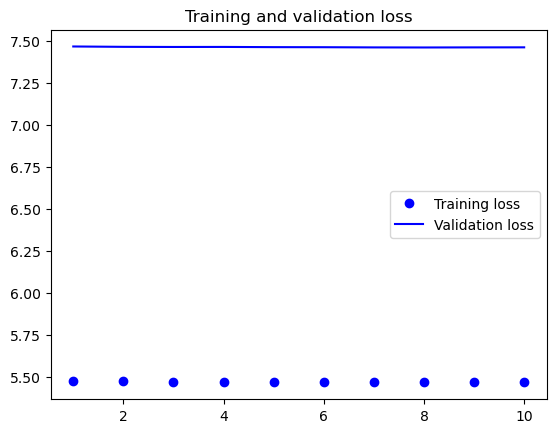

Training fold 0 - finished training
3410/3410 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3410/3410 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Training fold 0 - after training - train_manual_mae: 5.466484069824219, eval_manual_mae: 7.461743354797363


2024-04-14 18:45:41.642539: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 18:46:02.347601: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Training fold 0 - finished post processing
Training fold 0 - end
Training fold 1 - {
  "learning_rate": 1e-05,
  "epochs": 10,
  "batch_size": 256
}
Training fold 1 - start


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Training fold 1 - initialized
Training fold 1 - train size: (1745920, 13), eval size: (872960, 13)
6820/6820 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
3410/3410 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Training fold 1 - before training - train_manual_mae: 9.473047256469727, eval_manual_mae: 9.765624046325684
Training fold 1 - start training
Epoch 1/10
6820/6820 ━━━━━━━━━━━━━━━━━━━━ 67s 10ms/step - loss: 6.5174 - mae: 6.5174 - val_loss: 6.9048 - val_mae: 6.9048
Epoch 2/10
6820/6820 ━━━━━━━━━━━━━━━━━━━━ 69s 10ms/step - loss: 6.4656 - mae: 6.4656 - val_loss: 6.9084 - val_mae: 6.9084
Epoch 3/10
6820/6820 ━━━━━━━━━━━━━━━━━━━━ 68s 10ms/step - loss: 6.4601 - mae: 6.4601 - val_loss: 6.9014 - val_mae: 6.9014
Epoch 4/10
6820/6820 ━━━━━━━━━━━━━━━━━━━━ 70s 10ms/step - loss: 6.4669 - mae: 6.4669 - val_loss: 6.9032 - val_mae: 6.9032
Epoch 5/10
6820/6820 ━━━━━━━━━━━━━━━━━━━━ 68s 10ms/step - loss: 6.4694 - mae: 6.4694 - val_loss: 6.8973 - val_mae: 6.8973
Epoch 6/10
6820/6820 ━━━━━━━━━━━━━━━━━━━━ 67s 10ms/step - 

<Figure size 640x480 with 0 Axes>

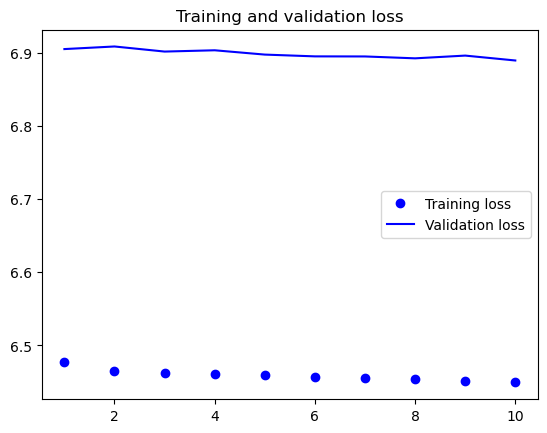

Training fold 1 - finished training
6820/6820 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
3410/3410 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Training fold 1 - after training - train_manual_mae: 6.446332931518555, eval_manual_mae: 6.889233112335205
Training fold 1 - finished post processing
Training fold 1 - end
Training fold 2 - {
  "learning_rate": 1e-05,
  "epochs": 10,
  "batch_size": 256
}
Training fold 2 - start


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Training fold 2 - initialized
Training fold 2 - train size: (2618880, 13), eval size: (872960, 13)
10230/10230 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
3410/3410 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Training fold 2 - before training - train_manual_mae: 16.115175247192383, eval_manual_mae: 15.800118446350098
Training fold 2 - start training
Epoch 1/10
10230/10230 ━━━━━━━━━━━━━━━━━━━━ 95s 9ms/step - loss: 6.9683 - mae: 6.9683 - val_loss: 6.1856 - val_mae: 6.1856
Epoch 2/10
10230/10230 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - loss: 6.6088 - mae: 6.6088 - val_loss: 6.1854 - val_mae: 6.1854
Epoch 3/10
10230/10230 ━━━━━━━━━━━━━━━━━━━━ 95s 9ms/step - loss: 6.6004 - mae: 6.6004 - val_loss: 6.1855 - val_mae: 6.1855
Epoch 4/10
10230/10230 ━━━━━━━━━━━━━━━━━━━━ 93s 9ms/step - loss: 6.6004 - mae: 6.6004 - val_loss: 6.1847 - val_mae: 6.1847
Epoch 5/10
10230/10230 ━━━━━━━━━━━━━━━━━━━━ 99s 10ms/step - loss: 6.6041 - mae: 6.6041 - val_loss: 6.1970 - val_mae: 6.1970
Epoch 6/10
10230/10230 ━━━━━━━━━━━━━━━━━━━━ 97s 

<Figure size 640x480 with 0 Axes>

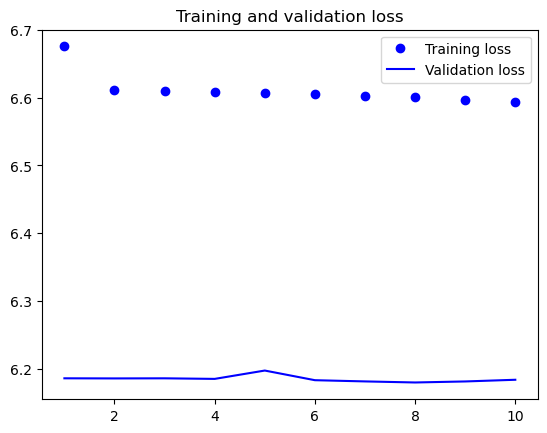

Training fold 2 - finished training
10230/10230 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
3410/3410 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Training fold 2 - after training - train_manual_mae: 6.593935012817383, eval_manual_mae: 6.183403491973877
Training fold 2 - finished post processing
Training fold 2 - end
Training fold 3 - {
  "learning_rate": 1e-05,
  "epochs": 10,
  "batch_size": 256
}
Training fold 3 - start


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Training fold 3 - initialized
Training fold 3 - train size: (3491840, 13), eval size: (872960, 13)
13640/13640 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
3410/3410 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Training fold 3 - before training - train_manual_mae: 9.71828842163086, eval_manual_mae: 9.660000801086426
Training fold 3 - start training
Epoch 1/10
13640/13640 ━━━━━━━━━━━━━━━━━━━━ 126s 9ms/step - loss: 6.5628 - mae: 6.5628 - val_loss: 6.4191 - val_mae: 6.4191
Epoch 2/10
13640/13640 ━━━━━━━━━━━━━━━━━━━━ 125s 9ms/step - loss: 6.5044 - mae: 6.5044 - val_loss: 6.4215 - val_mae: 6.4215
Epoch 3/10
13640/13640 ━━━━━━━━━━━━━━━━━━━━ 126s 9ms/step - loss: 6.5018 - mae: 6.5018 - val_loss: 6.4207 - val_mae: 6.4207
Epoch 4/10
13640/13640 ━━━━━━━━━━━━━━━━━━━━ 126s 9ms/step - loss: 6.5043 - mae: 6.5043 - val_loss: 6.4153 - val_mae: 6.4153
Epoch 5/10
13640/13640 ━━━━━━━━━━━━━━━━━━━━ 126s 9ms/step - loss: 6.4958 - mae: 6.4958 - val_loss: 6.4130 - val_mae: 6.4130
Epoch 6/10
13640/13640 ━━━━━━━━━━━━━━━━━━━━ 124

<Figure size 640x480 with 0 Axes>

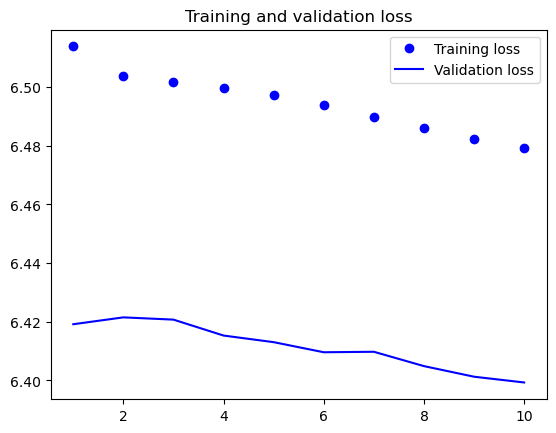

Training fold 3 - finished training
13640/13640 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
3410/3410 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Training fold 3 - after training - train_manual_mae: 6.476962089538574, eval_manual_mae: 6.399292469024658
Training fold 3 - finished post processing
Training fold 3 - end
Training fold 4 - {
  "learning_rate": 1e-05,
  "epochs": 10,
  "batch_size": 256
}
Training fold 4 - start


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Training fold 4 - initialized
Training fold 4 - train size: (4364800, 13), eval size: (872960, 13)
17050/17050 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
3410/3410 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Training fold 4 - before training - train_manual_mae: 12.500069618225098, eval_manual_mae: 12.319657325744629
Training fold 4 - start training
Epoch 1/10
17050/17050 ━━━━━━━━━━━━━━━━━━━━ 155s 9ms/step - loss: 6.6052 - mae: 6.6052 - val_loss: 5.9887 - val_mae: 5.9887
Epoch 2/10
17050/17050 ━━━━━━━━━━━━━━━━━━━━ 157s 9ms/step - loss: 6.4896 - mae: 6.4896 - val_loss: 5.9820 - val_mae: 5.9820
Epoch 3/10
17050/17050 ━━━━━━━━━━━━━━━━━━━━ 154s 9ms/step - loss: 6.4834 - mae: 6.4834 - val_loss: 5.9826 - val_mae: 5.9826
Epoch 4/10
17050/17050 ━━━━━━━━━━━━━━━━━━━━ 156s 9ms/step - loss: 6.4794 - mae: 6.4794 - val_loss: 5.9831 - val_mae: 5.9831
Epoch 5/10
17050/17050 ━━━━━━━━━━━━━━━━━━━━ 154s 9ms/step - loss: 6.4771 - mae: 6.4771 - val_loss: 5.9752 - val_mae: 5.9752
Epoch 6/10
17050/17050 ━━━━━━━━━━━━━━━━━━━━ 

<Figure size 640x480 with 0 Axes>

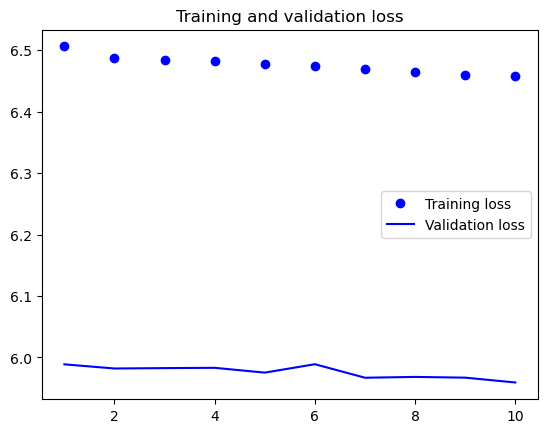

Training fold 4 - finished training
17050/17050 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
3410/3410 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Training fold 4 - after training - train_manual_mae: 6.453510761260986, eval_manual_mae: 5.959197521209717
Training fold 4 - finished post processing
Training fold 4 - end
finished training, num_train_eval_sets: 5


<Figure size 640x480 with 0 Axes>

In [21]:
for fold in range(num_train_eval_sets):
# for fold in range(4, 5):
    print(f"Training fold {fold} - {json.dumps(param, indent=2)}")
    
    print(f"Training fold {fold} - start")

    model_pipeline = mlp_model_pipeline_factory.create_model_pipeline()
    model_pipeline.init_model(
        param = param,
        fold=fold,
    )
    print(f"Training fold {fold} - initialized")

    fold_df_train = train_dfs[fold]
    fold_df_eval = eval_dfs[fold]
    print(f"Training fold {fold} - train size: {fold_df_train.shape}, eval size: {fold_df_eval.shape}")

    # normalize features, scaler per fold, fit on training set, transform both training and validation set
    scaler = preprocessing.StandardScaler()
    scaler.fit(fold_df_train[normalize_columns])
    fold_df_train[normalize_columns] = scaler.transform(fold_df_train[normalize_columns])
    fold_df_eval[normalize_columns] = scaler.transform(fold_df_eval[normalize_columns])

    X_train_fold, y_train_fold, X_val_fold, y_val_fold = model_pipeline.create_XY(fold_df_train, fold_df_eval)

    train_manual_mae = model_pipeline.eval_once(X_train_fold, y_train_fold)
    eval_manual_mae = model_pipeline.eval_once(X_val_fold, y_val_fold)
    print(f"Training fold {fold} - before training - train_manual_mae: {train_manual_mae}, eval_manual_mae: {eval_manual_mae}")

    print(f"Training fold {fold} - start training")
    train_res = model_pipeline.train(X_train_fold, y_train_fold, X_val_fold, y_val_fold, None)
    fold_model = model_pipeline.get_model()
    models.append(fold_model)
    model_res.append(train_res)
    print(f"Training fold {fold} - finished training")

    train_manual_mae = model_pipeline.eval_once(X_train_fold, y_train_fold)
    eval_manual_mae = model_pipeline.eval_once(X_val_fold, y_val_fold)
    print(f"Training fold {fold} - after training - train_manual_mae: {train_manual_mae}, eval_manual_mae: {eval_manual_mae}")
    
    model_post_processor.process(fold_model, model_pipeline, fold)
    print(f"Training fold {fold} - finished post processing")

    print(f"Training fold {fold} - end")

print(f"finished training, num_train_eval_sets: {num_train_eval_sets}")